In [1]:
import matplotlib.pyplot as plt
import pickle
import numpy as np
import networkx as nx
import torch
from scipy.linalg import eigh

In [447]:
dataset = 'MUTAG'
max_runs, max_folds =10, 10

min_runs = 0
max_epochs = 50

runs = range(min_runs, max_runs)
folds = range(max_folds)

test_loss = []
theta = []
train_loss = []

for run in runs:
    for fold in folds:
        run_fold_index = str(run) + '_' + str(fold)  + '.pkl'
        test_loss.append(pickle.load(open('../ten10folds/' + dataset + '/rbf12_maxH0H1rel/rbf12_maxH0H1rel_test_loss_' + run_fold_index, 'rb')))
        train_loss.append(pickle.load(open('../ten10folds/' + dataset + '/rbf12_maxH0H1rel/rbf12_maxH0H1rel_train_loss_' + run_fold_index, 'rb')))
        theta.append(pickle.load(open('../ten10folds/' + dataset + '/rbf12_maxH0H1rel/rbf12_maxH0H1rel_theta_' + run_fold_index, 'rb')))
    
theta = np.array(theta)
test_loss = np.array(test_loss)
train_loss = np.array(train_loss)

print(theta.shape, test_loss.shape, train_loss.shape)

(100, 150, 12, 1) (100, 50) (100, 50)


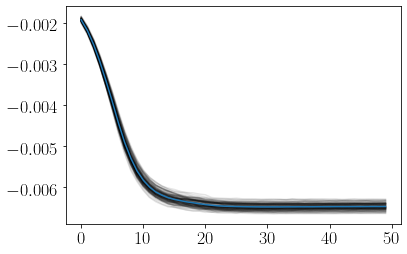

In [448]:
for t in train_loss:
    plt.plot(t, 'k-', alpha = 0.1)
plt.plot(np.mean(train_loss, axis = 0), 'tab:blue')

In [456]:
train_mean = np.mean(train_loss - np.reshape(train_loss[:,0], [-1, 1]), axis = 0)
test_mean = np.mean(test_loss - np.reshape(test_loss[:,0], [-1, 1]), axis = 0)
test_std = np.std(test_loss - np.reshape(test_loss[:,0], [-1, 1]), axis = 0)
train_std = np.std(train_loss - np.reshape(train_loss[:,0], [-1, 1]), axis = 0)

In [457]:
test_std[-1]/ train_std[-1]

8.79553209821784

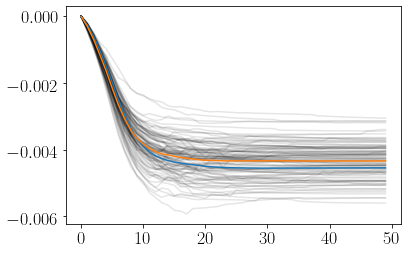

In [459]:
for t in test_loss:
    plt.plot(t - t[0], 'k-', alpha = 0.1)
plt.plot(train_mean, 'tab:blue')
plt.plot(test_mean, 'tab:orange')


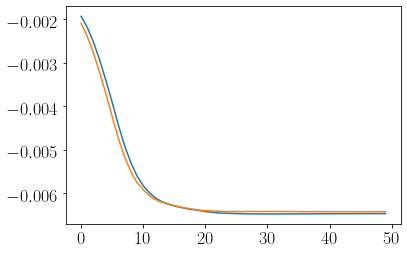

In [452]:
plt.plot(np.mean(train_loss, axis = 0), 'tab:blue')
plt.plot(np.mean(test_loss, axis = 0), 'tab:orange')

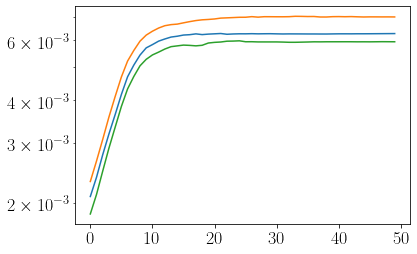

In [421]:
plt.semilogy(np.median(-test_loss, axis = 0))
plt.semilogy(np.quantile(-test_loss, 0.75, axis = 0))
plt.semilogy(np.quantile(-test_loss, 0.25, axis = 0))

In [409]:
np.linalg.norm(theta[0,0] - theta[0,-1]), np.linalg.norm(theta[0,0]), np.linalg.norm(theta[0,-1])

(1.4428444, 1.0245881, 1.0285655)

In [410]:
theta[-1,0] - theta[0,0]

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]], dtype=float32)

In [411]:
from matplotlib import rc

In [412]:
rc('text', usetex=True)
font = {'weight' : 'bold',
        'size'   : 18 , 
       'family': 'sans-serif'}
rc('font', **font)

In [480]:
param = 'rbf'
bfs = 12
if param == 'rbf':
    bfseps = 2/(bfs-3)
    centroids = torch.linspace(-bfseps, 2 + bfseps, bfs)

In [386]:

#datasets = ['IMDB-BINARY']

In [191]:
datasets = ['MUTAG','COX2', 'DHFR',  'NCI1', 'IMDB-BINARY',]
Slist_cheb = []
Slist_rbf = []
clique_count = 0
for dataset_name in  datasets:

    graph_list = pickle.load(open(dataset_name + '/networkx_graphs.pkl', 'rb'))
    data_len = len(graph_list)
    slist_rbf = []
    slist_cheb = []
    for i in range(data_len):
        G = graph_list[i]
        L = nx.normalized_laplacian_matrix(G)
        lam, v = eigh(L.todense())
        w = torch.from_numpy(lam).float()
        clique = G.number_of_edges()- len(G)*(len(G)-1)/2
        evecssq = torch.from_numpy(v**2).float()
       
        gram = 1/torch.sqrt((torch.reshape(w, [len(G), 1]) - centroids)**2/bfseps**2 + 1)
        A_rbf = torch.matmul(evecssq, gram)
        
        vander=  torch.from_numpy(np.polynomial.chebyshev.chebvander(lam, bfs+1)).float()
        A_cheb = torch.matmul(evecssq, vander[:, 2:])

        if clique <= -1:
            u, s_rbf, vh  = np.linalg.svd(A_rbf, full_matrices = False)
            #s.sort()
            slist_rbf.append(np.quantile(s_rbf, [0.25, 0.75]))
            #slist.append(s[-2:])
            u, s_cheb, vh  = np.linalg.svd(A_cheb, full_matrices = False)
            slist_cheb.append(np.quantile(s_cheb, [0.25, 0.75]))
        else:
            clique_count += 1
    Slist_rbf.append(slist_rbf)
    Slist_cheb.append(slist_cheb)

In [143]:
slist[-1]

array([0.5217734, 7.7878537], dtype=float32)

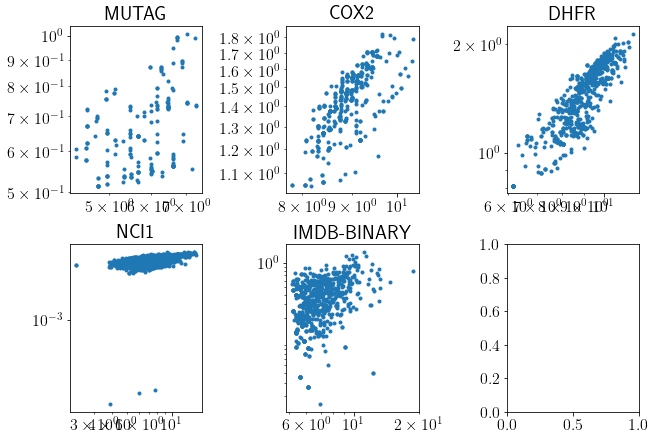

In [142]:
font = {'weight' : 'bold',
        'size'   : 16}
rc('font', **font)
fig0, f0_axes = plt.subplots(ncols=3, nrows=2, constrained_layout=True, figsize = [9, 6])

for row in range(2):
    if row == 0: 
        k = 3
    else:
        k = 2
    for col in range(k):
        ind = 3*row + col
        ax = f0_axes[row, col]
        

        s = np.array(Slist[ind])
        ax.loglog(s[:,1], s[:,0], '.')
        ax.yaxis.set_major_locator(plt.LogLocator(base=10, numticks=2))
        ax.xaxis.set_major_locator(plt.LogLocator(base=10, numticks=2))
        ax.set_title(datasets[ind])

    
    #ax.set_yticklabels(ax.get_yticks(), rotation='vertical')

In [144]:
dataset_name = 'COX2'
graph_list = pickle.load(open(dataset_name + '/networkx_graphs.pkl', 'rb'))
labels = np.array([G.graph['label'] for G in graph_list if 2*G.number_of_edges() < len(G)*(len(G)-1)])

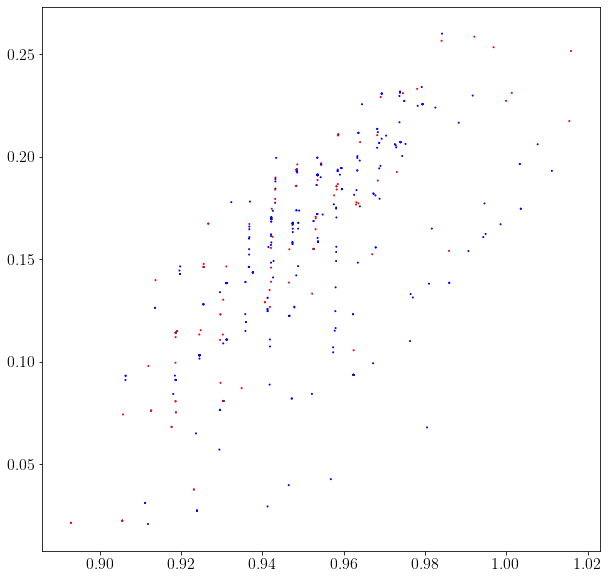

In [146]:
s = np.array(Slist[1])
fig = plt.figure(figsize = [10, 10])
ax = plt.gca()
ax.scatter(np.log10(s[:,1]), np.log10(s[:,0]), s = 1, c = labels, cmap ='bwr')
#ax.set_ylim([-10, -1])
#ax.set_xlim([-3, -1])

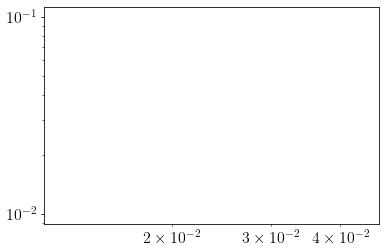

In [137]:
fig = plt.figure()
ax = plt.gca()
ax.scatter(s[:,1], s[:,0],  c = labels)
ax.set_yscale('log')
ax.set_xscale('log')

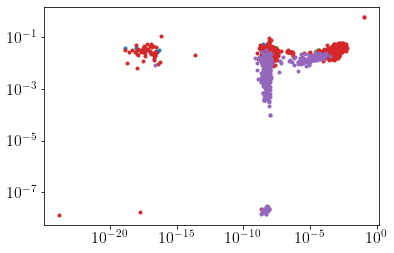

In [77]:
datasets = ['MUTAG','COX2', 'DHFR',  'NCI1', 'IMDB-B',]
for i in range(5):
    s = np.array(Slist[i])
    plt.loglog(s[:,0], s[:,1], '.', label = datasets[i])
#plt.legend()

In [193]:
ratios_cheb = []
ratios_rbf = []
for s in Slist_cheb:
    s = np.array(s)
    r = s[:,0]/s[:,1]
    r.sort()
    ratios_cheb.append(r)
for s in Slist_rbf:
    s = np.array(s)
    r = s[:,0]/s[:,1]
    r.sort()
    ratios_rbf.append(r)

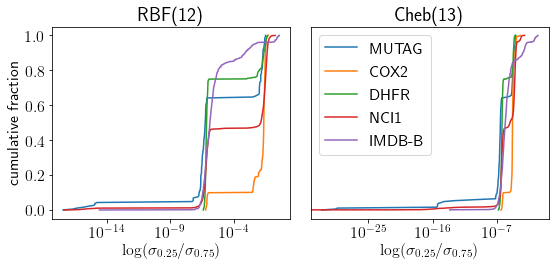

In [208]:
datasets = ['MUTAG','COX2', 'DHFR',  'NCI1', 'IMDB-B',]
fig0, f0_axes = plt.subplots(ncols=2, nrows=1, figsize = [8,4])

for i in range(5):
    r = ratios_rbf[i]
    f0_axes[0].semilogx(r, np.linspace(0, 1, len(r)), label = datasets[i])
    r = ratios_cheb[i]
    f0_axes[1].semilogx(r, np.linspace(0, 1, len(r)), label = datasets[i])
#f0_axes[0].legend()
f0_axes[0].set_title('RBF(12)')
f0_axes[1].set_title('Cheb(13)')
f0_axes[1].legend()
f0_axes[1].set_yticks([])
f0_axes[0].set_ylabel('cumulative fraction')
#plt.ylabel('cumulative fraction')
f0_axes[0].set_xlabel(r'$\log (\sigma_{0.25} / \sigma_{0.75})$')
f0_axes[1].set_xlabel(r'$\log (\sigma_{0.25} / \sigma_{0.75})$')
fig0.tight_layout()
plt.savefig('sigma_ratio_individual_rbf_cheb.pdf', dpi = 300)

In [206]:
np.linspace(-13, 0, 9)

array([-13.   , -11.375,  -9.75 ,  -8.125,  -6.5  ,  -4.875,  -3.25 ,
        -1.625,   0.   ])

In [89]:
for r in ratios:
    print(r[len(r)//2])

5.762309164578942e-07
0.023688910404098387
7.248256904199023e-07
0.013450351245379992
1.336676193502719e-06


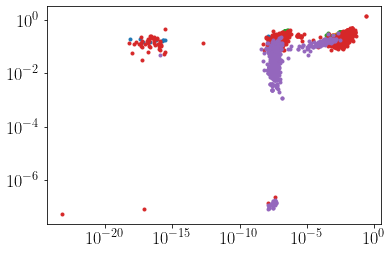

In [39]:
datasets = ['MUTAG','COX2', 'DHFR',  'NCI1', 'IMDB-B',]
for i in range(5):
    s = np.array(Slist[i])
    plt.loglog(s[:,0], s[:,1], '.', label = datasets[i])
#plt.legend()

In [481]:
datasets = ['MUTAG','COX2', 'DHFR',  'NCI1', 'PROTEINS', 'IMDB-BINARY',]
#datasets = ['MUTAG']
slist_cheb = None
slist_rbf = None
clique_count = 0
vh_cheb = []
vh_rbf = []
for dataset_name in  datasets:

    Alist_rbf = None
    Alist_cheb = None

    graph_list = pickle.load(open(dataset_name + '/networkx_graphs.pkl', 'rb'))
    data_len = len(graph_list)

    for i in range(data_len):
        G = graph_list[i]
        L = nx.normalized_laplacian_matrix(G)
        lam, v = eigh(L.todense())
        w = torch.from_numpy(lam).float()
        clique = G.number_of_edges()- len(G)*(len(G)-1)/2
        evecssq = torch.from_numpy(v**2).float()
        
        gram = 1/torch.sqrt((torch.reshape(w, [len(G), 1]) - centroids)**2/bfseps**2 + 1)
        A_rbf = torch.matmul(evecssq, gram)
            #A = A - torch.mean(A, dim = 0)
        
        vander=  torch.from_numpy(np.polynomial.chebyshev.chebvander(lam, bfs+1)).float()
        A_cheb = torch.matmul(evecssq, vander[:, 2:])

        if clique <= -1:
            if type(Alist_rbf) == type(None):
                Alist_rbf = A_rbf
            else:
                Alist_rbf = np.append(Alist_rbf, A_rbf, axis = 0)
                
            if type(Alist_cheb) == type(None):
                Alist_cheb= A_cheb
            else:
                Alist_cheb = np.append(Alist_cheb, A_cheb, axis = 0)
        else:
            clique_count += 1

    u, s_rbf, vh  = np.linalg.svd(Alist_rbf, full_matrices = False)
    vh_rbf.append(vh)
    u, s_cheb, vh  = np.linalg.svd(Alist_cheb, full_matrices = False)
    vh_cheb.append(vh)
    if type(slist_cheb) == type(None):
        slist_cheb = s_cheb
        slist_rbf  = s_rbf
    else:
        slist_cheb = np.append(slist_cheb, s_cheb)
        slist_rbf = np.append(slist_rbf, s_rbf)

In [462]:
clique_count / data_len

0.0

In [484]:
s_cheb

array([6.3051588e+05, 3.4559594e+04, 2.3844968e+03, 2.1581622e+02,
       3.4790272e+01, 1.5272617e+01, 1.2798853e+01, 6.6467137e+00,
       1.0648104e+00, 5.8719117e-02, 1.8596413e-03, 9.4784082e-05],
      dtype=float32)

In [486]:
slist_cheb = np.reshape(slist_cheb, [len(datasets),12])
slist_rbf = np.reshape(slist_rbf, [len(datasets),12])

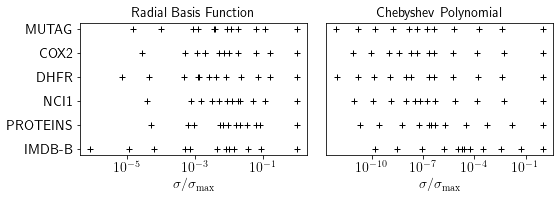

In [491]:
rc('text', usetex=True)
font = {'weight' : 'bold',
        'size'   : 14, 
       'family': 'sans-serif'}
rc('font', **font)

fig0, f0_axes = plt.subplots(ncols=2, nrows=1, figsize = [8,3])
n = len(datasets)
for i in range(n):
    f0_axes[0].semilogx(slist_rbf[n-1-i]/slist_rbf[n-1-i,0], i*np.ones(12), 'k+')
    f0_axes[1].semilogx(slist_cheb[n-1-i]/slist_cheb[n-1-i,0], i*np.ones(12), 'k+')

f0_axes[0].set_xlabel(r'${\sigma}/{\sigma_\mathrm{max}}$');
f0_axes[1].set_xlabel(r'${\sigma}/{\sigma_\mathrm{max}}$');
f0_axes[0].set_title('Radial Basis Function', fontsize=14)
f0_axes[1].set_title('Chebyshev Polynomial', fontsize=14)
f0_axes[0].set_yticks(np.arange(n)[::-1]);
f0_axes[0].set_yticklabels( ['MUTAG','COX2', 'DHFR', 'NCI1', 'PROTEINS', 'IMDB-B'])
#f0_axes[0].set_xticks(np.logspace(-7, 0, 8));
f0_axes[1].set_yticks([]); 
#f0_axes[1].set_xticks(np.logspace(-11, 0, 12));
fig0.tight_layout()
fig0.savefig('singular_rbfcheb_sixdatasets.pdf', dpi = 300)

In [472]:
centroids = np.linspace(-bfseps, 2 + bfseps, bfs)
t = np.reshape(np.linspace(0, 2, 50), [50, 1])
gram = 1/np.sqrt((t - centroids)**2/bfseps**2 + 1)

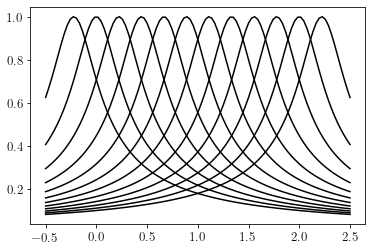

In [284]:
tt = np.linspace(-0.5, 2.5, 100)
for b in range(12):
    plt.plot(tt, 1/np.sqrt((tt - centroids[b])**2/bfseps**2 + 1), 'k-')

In [473]:
modes =[] 
for v in vh_rbf[-1]:
    m = np.matmul(gram, v)
    m -= np.mean(m)
    modes.append(m)
modes = np.array(modes)
modes.shape
modes = np.reshape(np.array(modes), [3,4, -1])

In [475]:
m.shape

(50,)

In [277]:
mn, mx = min(modes.flatten()), max(modes.flatten())

In [ ]:
mn, mx

0.23398245546829077
0.613898313698428
0.2774966945843009
0.16607957580395685
0.37878564512383556
0.11900286970498042
0.2049004970149739
0.11690490958111216
0.09930206677172124
0.2416545970838622
0.8018040396365532
0.51772051997595


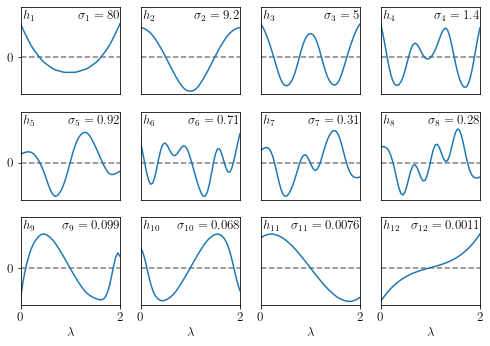

In [477]:
font = {'weight' : 'bold',
        'size'   : 13}
rc('font', **font)
fig1, f1_axes = plt.subplots(ncols=4, nrows=3, figsize = [7, 5])
#fig1.set_tight_layout(True)
for row in range(3):
    for col in range(4):
        order =  int(4*row + col + 1)
        ax = f1_axes[row, col]
        m = modes[row, col]
        ax.plot([0,2], [0, 0], 'grey', linestyle = '--')
        scale = max(abs(m))
        print(scale)
        ax.plot(t, m/scale, 'tab:blue')
        ax.set_xlim([0,2])
        #ax.set_ylim([max(m) - (max(m) - min(m)) *1.1, min(m) + (max(m) - min(m)) *1.3])
        #ax.set_ylim([mn, mn + (mx-mn) *1.3])
        ax.set_ylim([-1.1, 1.5])
        #ax.set_title(str(order))
        if col == 0: 
             ax.set( yticks=[0])
        else:
            ax.set( yticks=[])
        if row == 2: 
            ax.set_xticks([0,2])
            ax.set_xlabel(r'$\lambda$')
        else:
            ax.set_xticks([])
        #ax.text(0.975, 0.0, str(order),horizontalalignment='right',verticalalignment='bottom',transform=ax.transAxes)
        ax.text(0.025, 0.95, r"$h_{{{0}}}$".format(order),horizontalalignment='left',verticalalignment='top',transform=ax.transAxes)
        ax.text(1.0, 0.95, r"$\sigma_{{{0}}} = {1:.2g}$".format(order, slist_rbf[-1, order-1]),horizontalalignment='right',verticalalignment='top',transform=ax.transAxes)


fig1.tight_layout()
fig1.savefig('MUTAGwavelet_modes_unprimed.pdf', dpi = 300)

In [219]:
voltage = 220.0
idx = 3
print(r"\noindent $V_{0} = {1:.2} V$".format(idx, voltage))

\noindent $V_3 = 2.2e+02 V$


In [272]:
max(abs(m))

0.51772051997595